In [1]:
import tensorflow as tf;
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split as splitMe
%matplotlib inline

/home/ibu/anaconda3/envs/tf36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ibu/anaconda3/envs/tf36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Modelos finales con semilla fija; MSE para muestra de prueba; Histograma del error en muestras.

### The Winton Stock Market Challenge

https://www.kaggle.com/c/the-winton-stock-market-challenge/

In this competition the challenge is to predict the return of a stock, given the history of the past few days. 

We provide 5-day windows of time, days D-2, D-1, D, D+1, and D+2. You are given returns in days D-2, D-1, and part of day D, and you are asked to predict the returns in the rest of day D, and in days D+1 and D+2.

During day D, there is intraday return data, which are the returns at different points in the day. We provide 180 minutes of data, from t=1 to t=180. In the training set you are given the full 180 minutes, in the test set just the first 120 minutes are provided.

For each 5-day window, we also provide 25 features, Feature_1 to Feature_25. These may or may not be useful in your prediction.

Each row in the dataset is an arbitrary stock at an arbitrary 5 day time window.
![image.png](attachment:image.png)

### Primer Modelo:
Intentar precedir el rendimiento del día $D_{+1}$ utilizando las variables econonómicas y los rendimientos de $D_{-1}$ y $D_{-2}$

# Preprocesamiento de datos

Se cargan los datos y se aplica una Normalizacíon Gaussiana al conjunto de entrenamiento.

In [2]:
nEXTRA_FEATURES = 25;
nFEATURES = 121 -1 ;

In [3]:
trSet=pd.read_csv('./Data/Kaggle/train.csv',index_col=0);
trSet.fillna(trSet.mean(),inplace=True);

In [4]:
# X, Y = (trSet.iloc[:,nEXTRA_FEATURES:nEXTRA_FEATURES+nFEATURES+1],trSet.iloc[:,nEXTRA_FEATURES+nFEATURES+60+1]);
X, Y = (trSet.iloc[:,0:nEXTRA_FEATURES+2],trSet.iloc[:,nEXTRA_FEATURES+nFEATURES+60+1]);
miuY = Y.mean()
sigmaY = Y.std()
Xnorm = (X - X.mean())/X.std();
Ynorm = (Y - Y.mean())/Y.std();

In [5]:
Xnorm,Xnormt,Ynorm,Ynormt = splitMe(Xnorm,Ynorm, test_size=0.05, random_state=1995)

### Feature Exploration:
Como parte de la exploración de variables intentaremos visualizar por pares las variables independientes y con un mapa de color la variable dependiente que se intenta predecir. En concreto, se intenta ver si hay alguna transformación que ayude a separar los datos linealmente con las variables pareadas. Creamos una pila $Stack$ donde están las combinaciones de columnas. 27**C**2 plots - la diagonal ex [1,1],[2,2]

In [6]:
# # Pesado casi 27C2 plots!!!
# a = (nEXTRA_FEATURES + 2 )//2
# b = (nEXTRA_FEATURES + 2) - a
# stack = np.stack(np.meshgrid(np.arange(a),np.arange(a+b)), -1).reshape(-1, 2)
# for pair in stack:
#     plt.figure(figsize=(20,10))
#     ax = plt.gca()
# #     Enfocar plot a una desviación estandar
# #     ax.set_xlim([-1,1])
# #     ax.set_ylim([-1,1])
#     plt.scatter(Xnorm.iloc[:,pair[0]].values,Xnorm.iloc[:,pair[1]].values,c=Ynorm.values,cmap=cm.jet,alpha=.5)
#     plt.title("{}  {}".format(pair[0],pair[1]))
#     plt.colorbar()    
#     plt.show()

# Red convolucional

## Variables de la red

In [7]:
INPUT_SIZE = nFEATURES;
M = 3#12;
N = 9#10;
d1units = 12;
d2units = 12;
d3units = 12;
d1activation = tf.nn.sigmoid;
d2activation = tf.nn.sigmoid;
d3activation = tf.nn.sigmoid;
droprate = .4;
logitsunit = 1;
LEARNING_RATE = 0.01;
EPOCHS = 2000;
BATCH_SIZE = 1000;
n_batches = 1000;
SEED=1;
reg_scale = .9;
decay = .96;
decayiters = 100000;
test_length = Ynormt.size

In [8]:
featuresSet = Xnorm.values
labelsSet = Ynorm.values.reshape((-1,1))
mode = 'train'

featuresSetTest = Xnormt.values
labelsSetTest = Ynormt.values.reshape((-1,1))


    
batch_size = tf.placeholder(tf.int64);
x = tf.placeholder(tf.float32, shape=[None,featuresSet.size/len(featuresSet)]);
y = tf.placeholder(tf.float32, shape=[None,labelsSet.size/len(labelsSet)])    
dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(1000,seed=SEED).batch(BATCH_SIZE).repeat() #Could shuffle()
    
iterator = dataset.make_initializable_iterator()
features, labels = iterator.get_next()    
    
    
#   """Model function for NN."""

  # Input Layer
input_layer = tf.reshape(features, [-1, M*N])
    
dense1 = tf.layers.dense(inputs=input_layer, units=d1units, activation=d1activation)
    
x1_norm = tf.layers.batch_normalization(dense1,center=True, scale=True,
                                            training=mode == tf.estimator.ModeKeys.TRAIN)
    
dense2 = tf.layers.dense(inputs=x1_norm, units=d2units, activation=d2activation)
    
x2_norm = tf.layers.batch_normalization(dense2,center=True, scale=True,
                                            training=mode == tf.estimator.ModeKeys.TRAIN)    

#     Dense Layer 3 
dense3 = tf.layers.dense(inputs=x2_norm, units=d3units, activation=d3activation)
dropout = tf.layers.dropout(inputs=dense3, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)
    
#     Output layer
logits = tf.layers.dense(inputs=dropout, units=logitsunit)

loss = tf.losses.mean_squared_error(labels,logits)
loss += tf.losses.get_regularization_loss()
  # Configure the Training Op (for TRAIN mode)
if mode == tf.estimator.ModeKeys.TRAIN:        
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    global_step = tf.Variable(0)        
    optimizer = tf.train.AdamOptimizer(learning_rate=
                                        tf.train.exponential_decay(LEARNING_RATE,
                                                                    global_step,
                                                                    decayiters, decay, staircase=True))        
    train_op = optimizer.minimize(loss=loss,global_step=global_step)
        
    

In [9]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
            # initialise iterator with train data TODO
    sess.run(iterator.initializer, feed_dict={ x: featuresSet, y: labelsSet, batch_size: BATCH_SIZE})
    print('Training...')
    for i in range(EPOCHS):
        tot_loss = 0
        for _ in range(n_batches):                    
            _, loss_value = sess.run([train_op, loss])
            tot_loss += loss_value                    
        if (i+1) % 25 == 0:
            print("Epoch: {}, Loss: {:.4f}".format(i, tot_loss / n_batches))
    print("Training complete")
#             return sess
    # initialise iterator with test data
    mode = 'eval'
    sess.run(iterator.initializer, feed_dict={ x: featuresSetTest, y: labelsSetTest, batch_size: test_length})
    Yh,Y1,_,L = sess.run([logits,labels,train_op, loss])

Training...
Epoch: 24, Loss: 0.9024
Epoch: 49, Loss: 0.8987
Epoch: 74, Loss: 0.9017
Epoch: 99, Loss: 0.8989
Epoch: 124, Loss: 0.9003
Epoch: 149, Loss: 0.8955
Epoch: 174, Loss: 0.8967
Epoch: 199, Loss: 0.8953
Epoch: 224, Loss: 0.8964
Epoch: 249, Loss: 0.8975
Epoch: 274, Loss: 0.8972
Epoch: 299, Loss: 0.8971
Epoch: 324, Loss: 0.8948
Epoch: 349, Loss: 0.9031
Epoch: 374, Loss: 0.8947
Epoch: 399, Loss: 0.8969
Epoch: 424, Loss: 0.8953
Epoch: 449, Loss: 0.8952
Epoch: 474, Loss: 0.8951
Epoch: 499, Loss: 0.8945
Epoch: 524, Loss: 0.8967
Epoch: 549, Loss: 0.8948
Epoch: 574, Loss: 0.8969
Epoch: 599, Loss: 0.8964
Epoch: 624, Loss: 0.8942
Epoch: 649, Loss: 0.8955
Epoch: 674, Loss: 0.8955
Epoch: 699, Loss: 0.8964
Epoch: 724, Loss: 0.8942
Epoch: 749, Loss: 0.8945
Epoch: 774, Loss: 0.8942
Epoch: 799, Loss: 0.8948
Epoch: 824, Loss: 0.8958
Epoch: 849, Loss: 0.8947
Epoch: 874, Loss: 0.8934
Epoch: 899, Loss: 0.8923
Epoch: 924, Loss: 0.8914
Epoch: 949, Loss: 0.8956
Epoch: 974, Loss: 0.8938
Epoch: 999, Loss:

In [10]:
"Test Loss: {:.4f}".format(L)

'Test Loss: 1.2985'

In [11]:
def enframe(Yh,Y,miu,sigma):
    Yhu=Yh*sigma+miu
    Yu=Y1*sigma+miu

    a1= pd.DataFrame(Yhu)
    a1.columns = ['yhat']
    a2= pd.DataFrame(Yu)
    a2.columns = ['y']    
    return a1.join(a2)

In [12]:
aux = enframe(Yh,Y1,miuY,sigmaY)
E = aux.iloc[:,0].values - aux.iloc[:,1].values
SE = E@E
MSE = SE/len(E)
MSE

0.0008140712380409241

# Distribución del error para 'test'

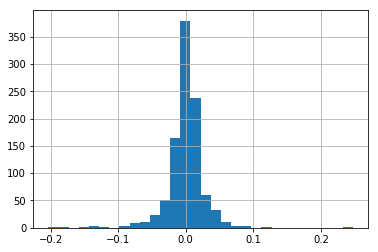

In [13]:
(aux.iloc[:,0]-aux.iloc[:,1]).hist(bins=30)

## Modelo 2: Red Convolucional

In [14]:
X, Y = (trSet.iloc[:,nEXTRA_FEATURES:nEXTRA_FEATURES+nFEATURES+1],trSet.iloc[:,nEXTRA_FEATURES+nFEATURES+60+1]);
miuY = Y.mean()
sigmaY = Y.std()
Xnorm = (X - X.mean())/X.std();
Ynorm = (Y - miuY)/sigmaY;

In [15]:
Xnorm,Xnormt,Ynorm,Ynormt = splitMe(Xnorm,Ynorm, test_size=0.05, random_state=1995)

In [16]:
INPUT_SIZE = X.columns.size;
M = 1;
N = INPUT_SIZE;
c1filter = 32;
c2filter = 16;
c1kernel = [1,3];
c2kernel = [1,2];
c1padding = 'same';
c2padding = 'same';
c1activation = None;
c2activation = None;
d1units = 8;
d1activation = tf.nn.sigmoid;
droprate = .4;
logitsunit = 1;
LEARNING_RATE = 0.1;
EPOCHS = 1000;
BATCH_SIZE = 200;
n_batches = 200;
SEED=2;
reg_scale = .9;
decay = .96;
decayiters = 100000;
test_length = Ynormt.size

In [17]:
   
featuresSet = Xnorm.values
labelsSet = Ynorm.values.reshape((-1,1))
mode = 'train'

featuresSetTest = Xnormt.values
labelsSetTest = Ynormt.values.reshape((-1,1))
    
batch_size = tf.placeholder(tf.int64);
x = tf.placeholder(tf.float32, shape=[None,featuresSet.size/len(featuresSet)]);
y = tf.placeholder(tf.float32, shape=[None,labelsSet.size/len(labelsSet)])    
dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(1000,seed=SEED).batch(BATCH_SIZE).repeat()
    
iterator = dataset.make_initializable_iterator()
features, labels = iterator.get_next()    
    
    
#   """Model function for CNN."""

  # Input Layer
input_layer = tf.reshape(features, [-1, M*N,1, 1])

  # Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs = input_layer,
    filters = c1filter,
    kernel_size = c1kernel,
    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=reg_scale),
    padding =c1padding,
    activation = c1activation)
    
x1_norm = tf.layers.batch_normalization(conv1,center=True, scale=True,
                                        training=mode == tf.estimator.ModeKeys.TRAIN)

  # Convolutional Layer #2
conv2 = tf.layers.conv2d(
    inputs = x1_norm,
    filters = c2filter,
    kernel_size = c2kernel,
    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=reg_scale),
    padding = c2padding,
    activation = c2activation)
    
x2_norm = tf.layers.batch_normalization(conv2,center=True, scale=True,
                                        training=mode == tf.estimator.ModeKeys.TRAIN)
  # Dense Layer
pool2_flat = tf.reshape(x2_norm, [-1, M * N * c2filter])
dense = tf.layers.dense(inputs=pool2_flat, units=d1units, activation=d1activation)
dropout = tf.layers.dropout(inputs=dense, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)
    
#     Output layer
logits = tf.layers.dense(inputs=dropout, units=logitsunit)

loss = tf.losses.mean_squared_error(labels,logits)
loss += tf.losses.get_regularization_loss()
  # Configure the Training Op (for TRAIN mode)
if mode == tf.estimator.ModeKeys.TRAIN:        
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    global_step = tf.Variable(0)        
    optimizer = tf.train.AdamOptimizer(learning_rate=
                                        tf.train.exponential_decay(LEARNING_RATE,
                                                                    global_step,
                                                                    decayiters, decay, staircase=True))        
    train_op = optimizer.minimize(loss=loss,global_step=global_step)
        
   

In [18]:
 with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # initialise iterator with train data TODO
        sess.run(iterator.initializer, feed_dict={ x: featuresSet, y: labelsSet, batch_size: BATCH_SIZE})
        print('Training...')
        for i in range(EPOCHS):
            tot_loss = 0
            for _ in range(n_batches):                    
                _, loss_value = sess.run([train_op, loss])
                tot_loss += loss_value                    
            if (i+1) % 25 == 0:
                print("Epoch: {}, Loss: {:.4f}".format(i, tot_loss / n_batches))
        print("Training complete")
    # initialise iterator with test data
        mode = 'eval'
        sess.run(iterator.initializer, feed_dict={ x: featuresSetTest, y: labelsSetTest, batch_size: test_length})
        Yh,Y1,_,L = sess.run([logits,labels,train_op, loss])

Training...
Epoch: 24, Loss: 0.9985
Epoch: 49, Loss: 0.9991
Epoch: 74, Loss: 1.0097
Epoch: 99, Loss: 1.0037
Epoch: 124, Loss: 0.9975
Epoch: 149, Loss: 1.0013
Epoch: 174, Loss: 1.0070
Epoch: 199, Loss: 1.0031
Epoch: 224, Loss: 1.0018
Epoch: 249, Loss: 1.0165
Epoch: 274, Loss: 1.0064
Epoch: 299, Loss: 1.0190
Epoch: 324, Loss: 1.0018
Epoch: 349, Loss: 0.9978
Epoch: 374, Loss: 1.0014
Epoch: 399, Loss: 1.0012
Epoch: 424, Loss: 1.0083
Epoch: 449, Loss: 1.0021
Epoch: 474, Loss: 1.0077
Epoch: 499, Loss: 1.0007
Epoch: 524, Loss: 1.0093
Epoch: 549, Loss: 1.0045
Epoch: 574, Loss: 0.9991
Epoch: 599, Loss: 1.0038
Epoch: 624, Loss: 1.0184
Epoch: 649, Loss: 1.0033
Epoch: 674, Loss: 1.0019
Epoch: 699, Loss: 1.0081
Epoch: 724, Loss: 1.0273
Epoch: 749, Loss: 0.9965
Epoch: 774, Loss: 1.0057
Epoch: 799, Loss: 1.0057
Epoch: 824, Loss: 1.0270
Epoch: 849, Loss: 1.0004
Epoch: 874, Loss: 1.0024
Epoch: 899, Loss: 1.0083
Epoch: 924, Loss: 1.0044
Epoch: 949, Loss: 1.0030
Epoch: 974, Loss: 0.9980
Epoch: 999, Loss:

In [19]:
"Test Loss: {:.4f}".format(L)

'Test Loss: 0.8189'

In [20]:
aux = enframe(Yh,Y1,miuY,sigmaY)
E = aux.iloc[:,0].values - aux.iloc[:,1].values
SE = E@E
MSE = SE/len(E)
MSE

0.0005124114453792572

# Distribución del error para 'test'

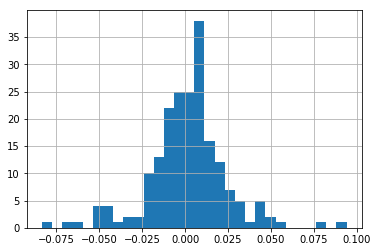

In [21]:
(aux.iloc[:,0]-aux.iloc[:,1]).hist(bins=30)